In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 21691275.56it/s]


Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 110424515.79it/s]


Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35704137.31it/s]


Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19107852.32it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)*0.95
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)*0.05
    return data.to(device)


In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:17,  6.82it/s]                         


Epoch 1 of 100
Generator loss: 2.56373882, Discriminator loss: 0.85992265


118it [00:14,  8.06it/s]                         


Epoch 2 of 100
Generator loss: 2.84930015, Discriminator loss: 0.83618450


118it [00:14,  8.00it/s]                         


Epoch 3 of 100
Generator loss: 0.92545062, Discriminator loss: 1.14983487


118it [00:16,  7.01it/s]                         


Epoch 4 of 100
Generator loss: 0.92733771, Discriminator loss: 1.24637938


118it [00:15,  7.86it/s]                         


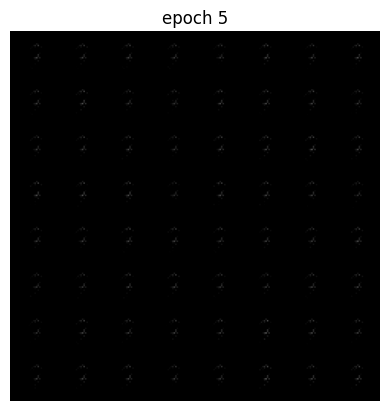

Epoch 5 of 100
Generator loss: 0.76824975, Discriminator loss: 1.20472527


118it [00:14,  8.08it/s]                         


Epoch 6 of 100
Generator loss: 0.58163518, Discriminator loss: 1.33139420


118it [00:14,  8.13it/s]                         


Epoch 7 of 100
Generator loss: 0.68432528, Discriminator loss: 1.37532604


118it [00:14,  7.88it/s]                         


Epoch 8 of 100
Generator loss: 0.86715615, Discriminator loss: 1.27516437


118it [00:14,  8.00it/s]                         


Epoch 9 of 100
Generator loss: 1.21298885, Discriminator loss: 0.97561711


118it [00:15,  7.84it/s]                         


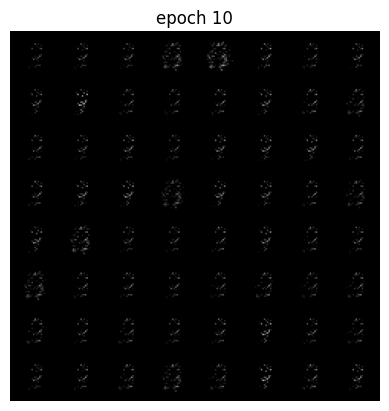

Epoch 10 of 100
Generator loss: 1.21474457, Discriminator loss: 0.91206962


118it [00:14,  8.03it/s]                         


Epoch 11 of 100
Generator loss: 1.17600441, Discriminator loss: 0.98102564


118it [00:14,  8.09it/s]                         


Epoch 12 of 100
Generator loss: 0.78911346, Discriminator loss: 1.02826273


118it [00:13,  8.50it/s]                         


Epoch 13 of 100
Generator loss: 1.68574333, Discriminator loss: 0.85643166


118it [00:14,  8.13it/s]                         


Epoch 14 of 100
Generator loss: 1.77591300, Discriminator loss: 0.71373039


118it [00:14,  8.27it/s]                         


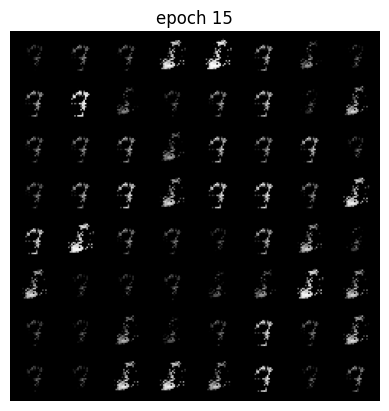

Epoch 15 of 100
Generator loss: 1.62967014, Discriminator loss: 0.83308733


118it [00:14,  8.06it/s]                         


Epoch 16 of 100
Generator loss: 1.56000102, Discriminator loss: 0.88824850


118it [00:14,  8.12it/s]                         


Epoch 17 of 100
Generator loss: 2.21843195, Discriminator loss: 0.77819812


118it [00:14,  7.95it/s]                         


Epoch 18 of 100
Generator loss: 2.32330918, Discriminator loss: 0.72749782


118it [00:15,  7.83it/s]                         


Epoch 19 of 100
Generator loss: 2.04559278, Discriminator loss: 0.86349344


118it [00:15,  7.69it/s]                         


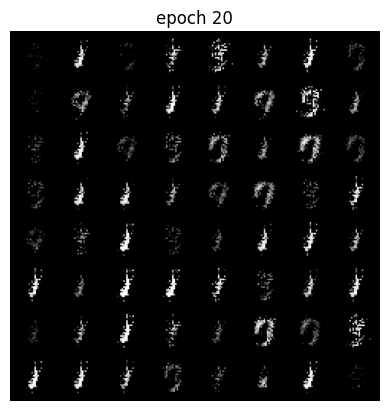

Epoch 20 of 100
Generator loss: 1.85445225, Discriminator loss: 0.85420924


118it [00:14,  7.90it/s]                         


Epoch 21 of 100
Generator loss: 2.08420825, Discriminator loss: 0.80006516


118it [00:14,  7.91it/s]                         


Epoch 22 of 100
Generator loss: 1.94419026, Discriminator loss: 0.84965372


118it [00:14,  7.90it/s]                         


Epoch 23 of 100
Generator loss: 1.82123303, Discriminator loss: 0.91801488


118it [00:15,  7.58it/s]                         


Epoch 24 of 100
Generator loss: 1.77461553, Discriminator loss: 0.91992962


118it [00:14,  7.92it/s]                         


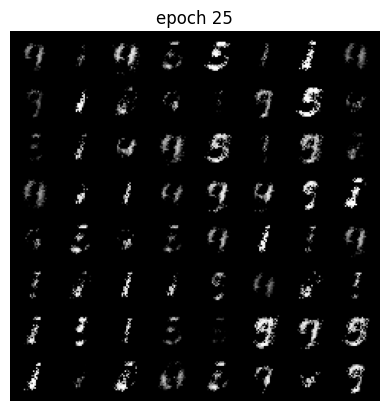

Epoch 25 of 100
Generator loss: 2.16860104, Discriminator loss: 0.83544463


118it [00:14,  8.08it/s]                         


Epoch 26 of 100
Generator loss: 1.68885863, Discriminator loss: 0.97145492


118it [00:14,  8.32it/s]                         


Epoch 27 of 100
Generator loss: 1.88769746, Discriminator loss: 0.91739452


118it [00:14,  8.32it/s]                         


Epoch 28 of 100
Generator loss: 1.80475974, Discriminator loss: 0.93838096


118it [00:14,  8.17it/s]                         


Epoch 29 of 100
Generator loss: 1.70804000, Discriminator loss: 0.98979539


118it [00:15,  7.60it/s]                         


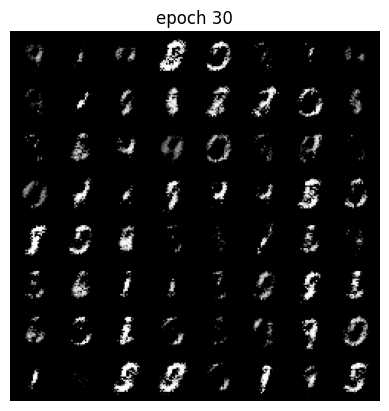

Epoch 30 of 100
Generator loss: 1.88616824, Discriminator loss: 0.93511689


118it [00:14,  7.92it/s]                         


Epoch 31 of 100
Generator loss: 1.91650629, Discriminator loss: 0.93383086


118it [00:14,  7.87it/s]                         


Epoch 32 of 100
Generator loss: 1.93990731, Discriminator loss: 0.92479563


118it [00:14,  8.09it/s]                         


Epoch 33 of 100
Generator loss: 1.87314916, Discriminator loss: 0.93840611


118it [00:14,  8.00it/s]                         


Epoch 34 of 100
Generator loss: 1.96723676, Discriminator loss: 0.93276870


118it [00:15,  7.58it/s]                         


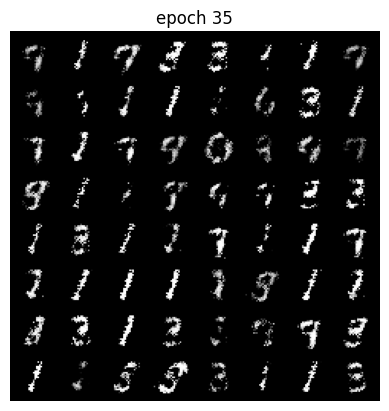

Epoch 35 of 100
Generator loss: 2.06137896, Discriminator loss: 0.92083198


118it [00:14,  7.93it/s]                         


Epoch 36 of 100
Generator loss: 2.06436276, Discriminator loss: 0.91068381


118it [00:14,  8.15it/s]                         


Epoch 37 of 100
Generator loss: 1.96366358, Discriminator loss: 0.92974436


118it [00:14,  7.93it/s]                         


Epoch 38 of 100
Generator loss: 1.82967317, Discriminator loss: 0.97228122


118it [00:15,  7.72it/s]                         


Epoch 39 of 100
Generator loss: 1.85130084, Discriminator loss: 0.97986805


118it [00:15,  7.52it/s]                         


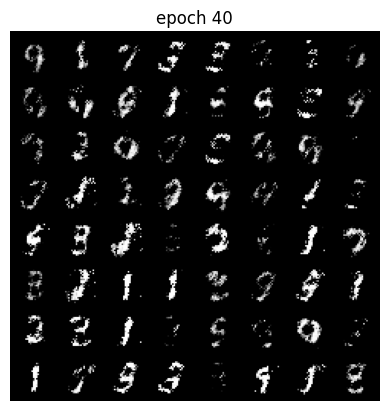

Epoch 40 of 100
Generator loss: 1.75435913, Discriminator loss: 0.99871653


118it [00:14,  7.97it/s]                         


Epoch 41 of 100
Generator loss: 1.69835246, Discriminator loss: 1.02380443


118it [00:15,  7.85it/s]                         


Epoch 42 of 100
Generator loss: 1.69415462, Discriminator loss: 1.01569223


118it [00:15,  7.81it/s]                         


Epoch 43 of 100
Generator loss: 1.65529323, Discriminator loss: 1.02657926


118it [00:15,  7.72it/s]                         


Epoch 44 of 100
Generator loss: 1.75103581, Discriminator loss: 1.01264334


118it [00:15,  7.83it/s]                         


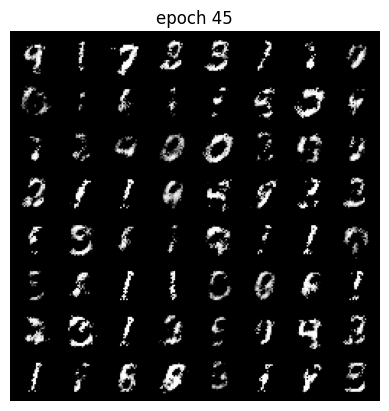

Epoch 45 of 100
Generator loss: 1.55253601, Discriminator loss: 1.05693388


118it [00:15,  7.78it/s]                         


Epoch 46 of 100
Generator loss: 1.59819090, Discriminator loss: 1.04160225


118it [00:15,  7.85it/s]                         


Epoch 47 of 100
Generator loss: 1.53703392, Discriminator loss: 1.07316840


118it [00:15,  7.66it/s]                         


Epoch 48 of 100
Generator loss: 1.54414988, Discriminator loss: 1.07642698


118it [00:15,  7.62it/s]                         


Epoch 49 of 100
Generator loss: 1.52004135, Discriminator loss: 1.07203376


118it [00:14,  8.04it/s]                         


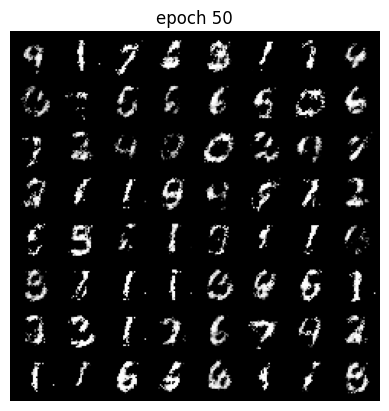

Epoch 50 of 100
Generator loss: 1.49686444, Discriminator loss: 1.07591844


118it [00:14,  7.92it/s]                         


Epoch 51 of 100
Generator loss: 1.51984918, Discriminator loss: 1.08288765


118it [00:15,  7.72it/s]                         


Epoch 52 of 100
Generator loss: 1.54651296, Discriminator loss: 1.07172012


118it [00:15,  7.76it/s]                         


Epoch 53 of 100
Generator loss: 1.54757130, Discriminator loss: 1.06369483


118it [00:15,  7.61it/s]                         


Epoch 54 of 100
Generator loss: 1.58558857, Discriminator loss: 1.06478238


118it [00:14,  7.89it/s]                         


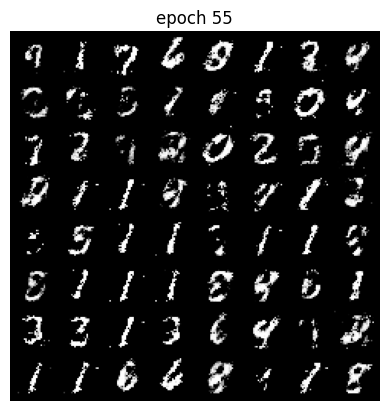

Epoch 55 of 100
Generator loss: 1.56822503, Discriminator loss: 1.06821191


118it [00:15,  7.77it/s]                         


Epoch 56 of 100
Generator loss: 1.50869405, Discriminator loss: 1.07505524


118it [00:14,  7.90it/s]                         


Epoch 57 of 100
Generator loss: 1.49251723, Discriminator loss: 1.08005977


118it [00:15,  7.71it/s]                         


Epoch 58 of 100
Generator loss: 1.47783756, Discriminator loss: 1.07708168


118it [00:15,  7.44it/s]                         


Epoch 59 of 100
Generator loss: 1.45919645, Discriminator loss: 1.08687162


118it [00:15,  7.57it/s]                         


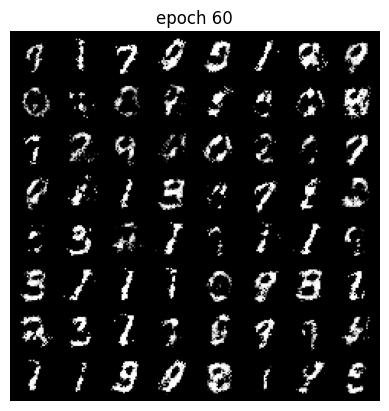

Epoch 60 of 100
Generator loss: 1.37918425, Discriminator loss: 1.10418773


118it [00:15,  7.68it/s]                         


Epoch 61 of 100
Generator loss: 1.44592059, Discriminator loss: 1.08571100


118it [00:15,  7.61it/s]                         


Epoch 62 of 100
Generator loss: 1.34524155, Discriminator loss: 1.12266684


118it [00:16,  7.30it/s]                         


Epoch 63 of 100
Generator loss: 1.39150059, Discriminator loss: 1.10771680


118it [00:15,  7.50it/s]                         


Epoch 64 of 100
Generator loss: 1.35331559, Discriminator loss: 1.11053836


118it [00:15,  7.63it/s]                         


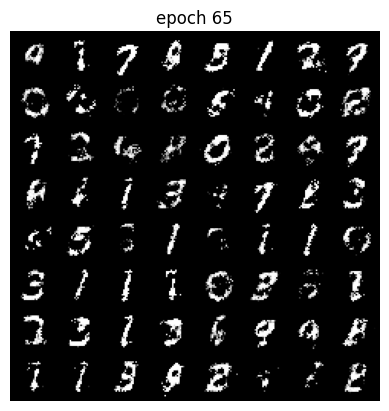

Epoch 65 of 100
Generator loss: 1.27398431, Discriminator loss: 1.15095842


118it [00:15,  7.58it/s]                         


Epoch 66 of 100
Generator loss: 1.32574081, Discriminator loss: 1.14251709


118it [00:16,  7.15it/s]                         


Epoch 67 of 100
Generator loss: 1.29184067, Discriminator loss: 1.13879573


118it [00:15,  7.55it/s]                         


Epoch 68 of 100
Generator loss: 1.24325323, Discriminator loss: 1.16092086


118it [00:15,  7.66it/s]                         


Epoch 69 of 100
Generator loss: 1.25124824, Discriminator loss: 1.16091609


118it [00:15,  7.83it/s]                         


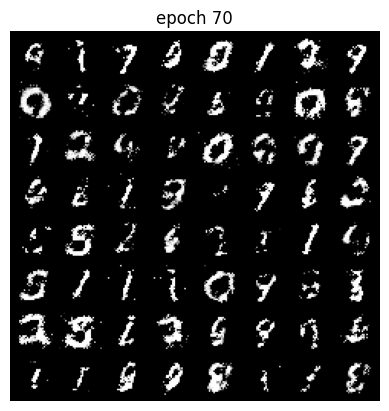

Epoch 70 of 100
Generator loss: 1.29792035, Discriminator loss: 1.12961257


118it [00:16,  7.34it/s]                         


Epoch 71 of 100
Generator loss: 1.35981464, Discriminator loss: 1.11634529


118it [00:15,  7.54it/s]                         


Epoch 72 of 100
Generator loss: 1.31967866, Discriminator loss: 1.13430357


118it [00:15,  7.57it/s]                         


Epoch 73 of 100
Generator loss: 1.25199449, Discriminator loss: 1.14691973


118it [00:15,  7.77it/s]                         


Epoch 74 of 100
Generator loss: 1.27806437, Discriminator loss: 1.15288579


118it [00:15,  7.41it/s]                         


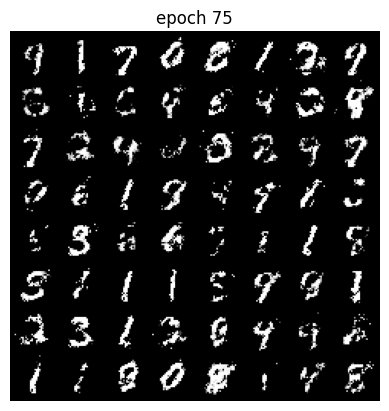

Epoch 75 of 100
Generator loss: 1.28052187, Discriminator loss: 1.13934684


118it [00:15,  7.54it/s]                         


Epoch 76 of 100
Generator loss: 1.20419097, Discriminator loss: 1.15878928


118it [00:15,  7.55it/s]                         


Epoch 77 of 100
Generator loss: 1.24974644, Discriminator loss: 1.16078103


118it [00:15,  7.53it/s]                         


Epoch 78 of 100
Generator loss: 1.16394353, Discriminator loss: 1.17998147


118it [00:16,  7.20it/s]                         


Epoch 79 of 100
Generator loss: 1.14773202, Discriminator loss: 1.17511404


118it [00:14,  7.91it/s]                         


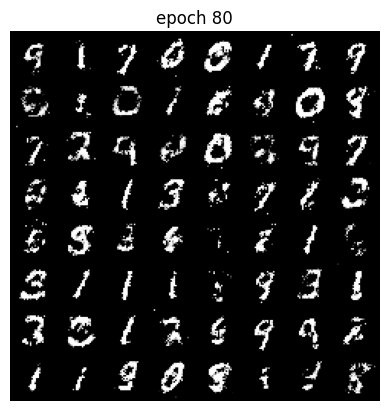

Epoch 80 of 100
Generator loss: 1.16099203, Discriminator loss: 1.18356180


118it [00:15,  7.76it/s]                         


Epoch 81 of 100
Generator loss: 1.18059540, Discriminator loss: 1.18096960


118it [00:14,  7.90it/s]                         


Epoch 82 of 100
Generator loss: 1.11637592, Discriminator loss: 1.19662797


118it [00:15,  7.43it/s]                         


Epoch 83 of 100
Generator loss: 1.13920856, Discriminator loss: 1.19683921


118it [00:16,  7.25it/s]                         


Epoch 84 of 100
Generator loss: 1.14330900, Discriminator loss: 1.18892586


118it [00:15,  7.62it/s]                         


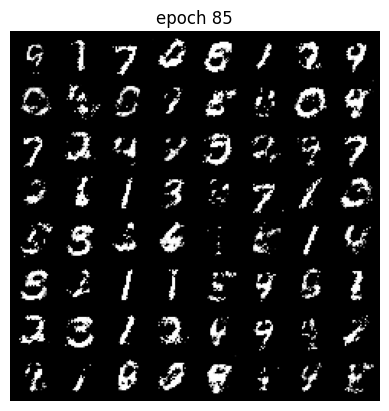

Epoch 85 of 100
Generator loss: 1.13961816, Discriminator loss: 1.19437373


118it [00:15,  7.60it/s]                         


Epoch 86 of 100
Generator loss: 1.17105627, Discriminator loss: 1.18099725


118it [00:15,  7.58it/s]                         


Epoch 87 of 100
Generator loss: 1.10649204, Discriminator loss: 1.20328104


118it [00:16,  7.10it/s]                         


Epoch 88 of 100
Generator loss: 1.13291430, Discriminator loss: 1.18846798


118it [00:15,  7.57it/s]                         


Epoch 89 of 100
Generator loss: 1.10520649, Discriminator loss: 1.22150016


118it [00:15,  7.86it/s]                         


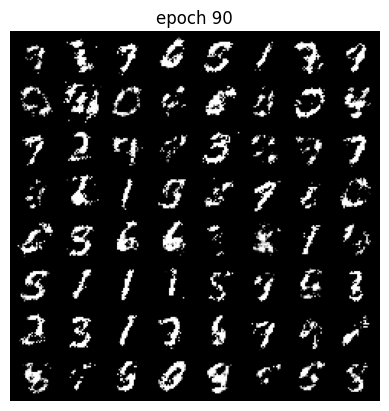

Epoch 90 of 100
Generator loss: 1.09267628, Discriminator loss: 1.22137773


118it [00:15,  7.63it/s]                         


Epoch 91 of 100
Generator loss: 1.07423735, Discriminator loss: 1.21986187


118it [00:15,  7.51it/s]                         


Epoch 92 of 100
Generator loss: 1.13253391, Discriminator loss: 1.19690752


118it [00:14,  7.89it/s]                         


Epoch 93 of 100
Generator loss: 1.09493744, Discriminator loss: 1.19140339


118it [00:15,  7.85it/s]                         


Epoch 94 of 100
Generator loss: 1.11153805, Discriminator loss: 1.20113671


118it [00:15,  7.56it/s]                         


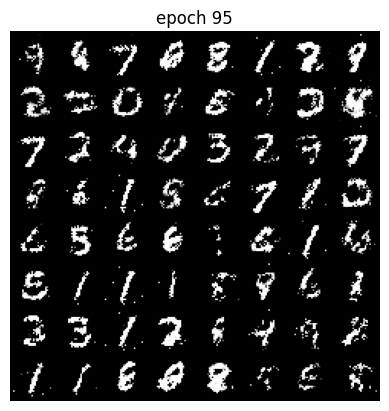

Epoch 95 of 100
Generator loss: 1.10865808, Discriminator loss: 1.19431806


118it [00:15,  7.40it/s]                         


Epoch 96 of 100
Generator loss: 1.08491421, Discriminator loss: 1.19746745


118it [00:15,  7.39it/s]                         


Epoch 97 of 100
Generator loss: 1.07438779, Discriminator loss: 1.21556103


118it [00:15,  7.47it/s]                         


Epoch 98 of 100
Generator loss: 1.00619841, Discriminator loss: 1.23177004


118it [00:15,  7.53it/s]                         


Epoch 99 of 100
Generator loss: 1.06562173, Discriminator loss: 1.21735215


118it [00:15,  7.41it/s]                         


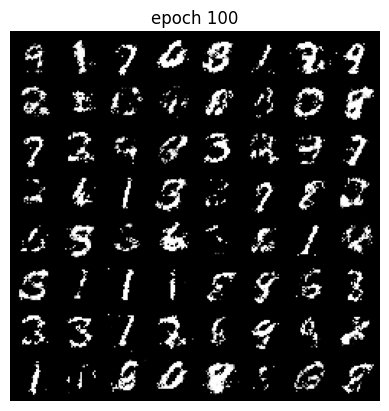

Epoch 100 of 100
Generator loss: 1.02122903, Discriminator loss: 1.22273505


In [14]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    return criterion(output,true_label)


    ######################################

def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    loss = criterion(output, true_label)
    return loss

    ######################################


for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
      ############ YOUR CODE HERE ##########

      ##Training Discriminator
      real_data, _ = data
      real_data = real_data.cuda()

      batch_size = real_data.shape[0]

      ##Train on Real data
      #adding the noise
      gaussian_noise = torch.randn_like(real_data)
      real_data = real_data + gaussian_noise

      optim_d.zero_grad()
      predictions_real = discriminator(real_data).view(-1)
      target_real = label_real(predictions_real.shape[0]).squeeze(1)
      disc_loss_real = discriminator_loss(predictions_real, target_real)
      disc_loss_real.backward()
      ##Train on Fake Data from generator
      rand_noise = create_noise(batch_size, nz)
      fake_images = generator(rand_noise)
      gaussian_noise = torch.randn_like(real_data)
      predictions_fake = discriminator(fake_images.detach()+gaussian_noise).view(-1)

      target_fake = label_fake(predictions_fake.shape[0]).squeeze(1)
      disc_loss_fake = discriminator_loss(predictions_fake, target_fake)
      disc_loss_fake.backward()
      optim_d.step()


      loss_d += disc_loss_real + disc_loss_fake

      ##Generator Training
      optim_g.zero_grad()
      rand_noise = create_noise(batch_size, nz)
      fake_images = generator(rand_noise)
      predictions_disc = discriminator(fake_images).view(-1)

      target_true_generator = label_real(predictions_disc.shape[0]).squeeze(1)
      loss_generator = generator_loss(predictions_disc, target_true_generator)

      loss_generator.backward()

      loss_g += loss_generator

      optim_g.step()










        ######################################


    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()

    # make the images as grid
    generated_img = make_grid(generated_img)

    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [15]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [16]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

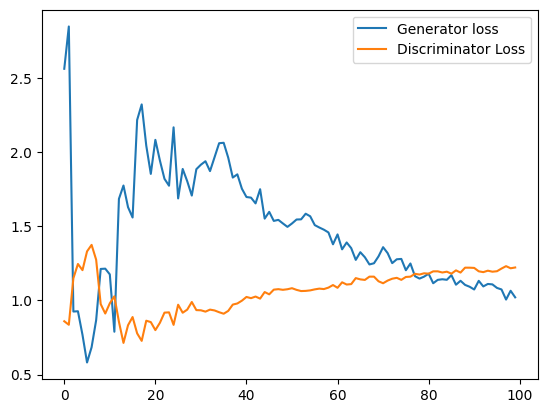

In [17]:
# # plot and save the generator and discriminator loss

numpy_list_d = [tensor.cpu().detach().numpy() for tensor in losses_d]
numpy_list_g = [tensor.cpu().detach().numpy() for tensor in losses_g]
plt.figure()
plt.plot(numpy_list_g, label='Generator loss')
plt.plot(numpy_list_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')

In [18]:
# # plot and save the generator and discriminator loss
# plt.figure()
# plt.plot(losses_g, label='Generator loss')
# plt.plot(losses_d, label='Discriminator Loss')
# plt.legend()
# plt.savefig('outputs/loss.png')

In [19]:
import shutil

# Define the path to the folder you want to zip
folder_path = '/content/outputs'  # Update this with your folder path

# Define the name for the zip file
zip_filename = '/content/outputs_3.zip'  # Update this with your desired zip file name

# Zip the folder
shutil.make_archive(zip_filename.split('.zip')[0], 'zip', folder_path)


'/content/outputs_3.zip'